In [3]:
import nibabel as nib
import argparse
import numpy as np
from matplotlib import pyplot as plt
import time 
from scipy import signal 
from sklearn.preprocessing import normalize
import os
import pandas as pd # for using pandas daraframe
import numpy as np # for som math operations
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
import matplotlib.pyplot as plt # for plotting
from glob import glob 
from sklearn import linear_model
import numpy as np
import matplotlib.pylab as pl

from glob import glob




%matplotlib inline 


In [2]:
def get_pcas(X, num_timeseries=4):
    # time on rows, X
    # voxels on columns, Y

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X) 

    ###########################
    # #NUMBER COMPONENTS 
    # pca = PCA()
    # X_pca = pca.fit(X_std)
    # X_pca.explained_variance_.shape 

    # num_components = 4
    # pca = PCA(num_components)  
    # X_pca = pca.fit_transform(X_std)

    ##########################
    # VARIANCE EXPLAINED 
    pca             = PCA(n_components = 0.99)
    X_pca           = pca.fit_transform(X_std) 
    n_pcs           = pca.n_components_ 

    most_important          = [ np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names   = [ x for x in range(0,X_std.shape[1])]
    most_important_names    = [ initial_feature_names[most_important[i]] for i in range(n_pcs)]

    #num_timeseries = 4
    most_important_timeseries = [ X_std[:,x] for x in most_important_names[0:num_timeseries] ]

    return most_important_timeseries

def preproc(ts): 
    #target_ts_mean          = np.mean(target_ts_list,0)
    target_ts_mean_dt       = signal.detrend(ts, type='linear')
    target_ts_mean_dt_norm  = (target_ts_mean_dt - 
                        np.mean(target_ts_mean_dt))/ np.std(target_ts_mean_dt)

    return target_ts_mean_dt_norm 


def plot_and_regress_layers(seed, control, layers ):
    #glm_input = epi_seed_mean - epi_control_mean
    #glm_input = pcas_seed[0] - pcas_control[0]


    seed = preproc(seed)
    control = preproc(control)
    
    layers = [preproc(l) for l in layers ]
    
    
    
    glm_input = seed - control 
    
    plt.figure()
    plt.plot(seed)
    plt.plot(control)
    plt.plot(glm_input)
    
    
    reg = linear_model.LinearRegression()

    reg.fit(layers.T, glm_input)



    coefs = reg.coef_
    
    plt.figure()
    plt.plot(coefs)




In [3]:

outdir='/home/kleinrl/regress_layers'

if not os.path.exists(outdir):
    os.makedirs(outdir)

VASO_dir='/data/kleinrl/ds003216/derivatives/sub-01/VASO_func/'
recon_dir="/data/kleinrl/ds003216/sub-01/ses-01/anat/" +
            "sub-01_ses-01_run-01_T1w_working_recon-all/sub-01_ses-01_run-01_T1w/"

EPIs=glob(VASO_dir + '*VASO.nii')

for EPI in EPIs: 


    #epi='/data/kleinrl/ds003216/derivatives/sub-01/VASO_func/sub-01_ses-06_task-movie_run-05_VASO.nii'
    layer4EPI_base = EPI.split('/')[-1].split('.')[0]
    layer4EPI      = recon_dir + '/LAYNII_'+layer4EPI_base

    
    
    seed     = layer4EPI + '/rois.thalamic.l3/8109.lh.LGN.nii' 
    control  = layer4EPI + '/rois.hcp/1023.L_MT.nii'
    #target  = layer4EPI + 'rois.hcp/1001.L_V1.nii'  
    target   = glob(layer4EPI + '/rois.hcp.l3/1001.L_V1.*.nii')  


    #out_prefix = '.'.join(target[0].split('/')[-1].strip('.nii').split('.')[0:-1])
    out_prefix = target[0].split('/')[-1].strip('.nii')

    start = time.perf_counter()


    # INDS ########################
    # SEED 
    nii_seed = nib.load(seed)
    data_seed = nii_seed.get_fdata()
    ind_seed = np.where(data_seed == 1)

    # TARGET 
    ind_targets = [] 
    for t in target:
        nii_target = nib.load(t)
        data_target = nii_target.get_fdata()
        ind_target = np.where(data_target == 1)
        ind_targets.append(ind_target)


    # CONTROL 
    nii_control = nib.load(control)
    data_control = nii_control.get_fdata()
    ind_control = np.where(data_control == 1)


    ###############
    # DATA 
    nii_epi = nib.load(epi)
    data_epi = nii_epi.get_fdata()


    # get TSs 
    epi_seed = data_epi[ind_seed]
    epi_seed_mean = np.mean(epi_seed, 0)
    pcas_seed = get_pcas(epi_seed.T, num_timeseries=4)


    epi_control = data_epi[ind_control]
    epi_control_mean = np.mean(epi_control, 0) 
    pcas_control = get_pcas(epi_control.T, num_timeseries=4)


    epi_targets = []
    epi_targets_mean = [] 
    pcas_targets = [] 

    for t in ind_targets: 
        epi_targets.append(data_epi[t])
        epi_targets_mean.append(np.mean(data_epi[t], 0))
        pcas_targets.append(get_pcas(data_epi[t].T, num_timeseries=4))

    epi_targets_mean = np.array(epi_targets_mean)

    epi_target_mean = np.mean(epi_targets_mean, 0)
    epi_targets_mean = epi_targets_mean - epi_target_mean 


    glm_input = epi_seed_mean - epi_control_mean
    glm_input = pcas_seed[0] - pcas_control[0]





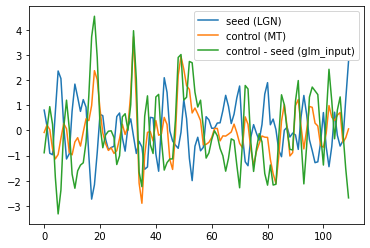

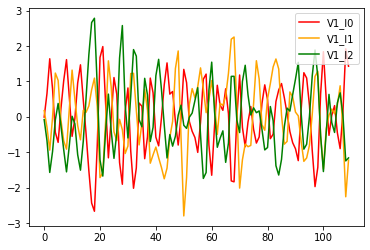

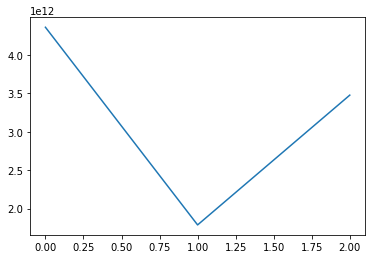

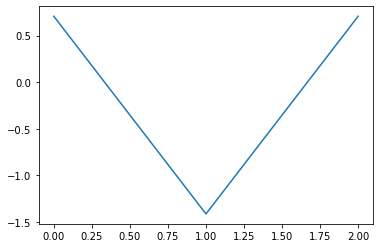

In [4]:
#plot_and_regress_layers(epi_control_mean, epi_seed_mean, epi_targets_mean)


seed = preproc(epi_seed_mean)
control = preproc(epi_control_mean)

layers = [preproc(l) for l in epi_targets_mean ]
layers = np.array(layers) 
layers.shape



glm_input = control - seed 



plt.figure()
plt.plot(seed, label='seed (LGN)')
plt.plot(control, label='control (MT)')
plt.plot(glm_input, label='control - seed (glm_input)')
plt.legend()


n=len(layers)
    
colors = pl.cm.jet(np.linspace(0,1,n))
colors = ['red','orange','green']

plt.figure()
for l in range(len(layers)):
    plt.plot(layers[l], label='V1_l{}'.format(l), color=colors[l])
plt.legend()



reg = linear_model.LinearRegression()

reg.fit(layers.T, glm_input)



coefs = reg.coef_

plt.figure()
plt.plot(coefs)

plt.figure()
plt.plot(preproc(coefs))





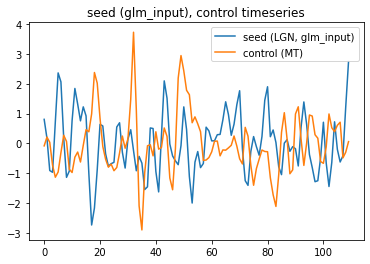

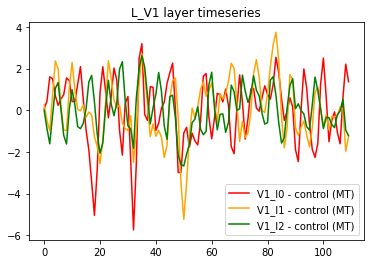

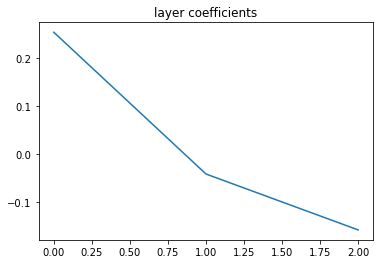

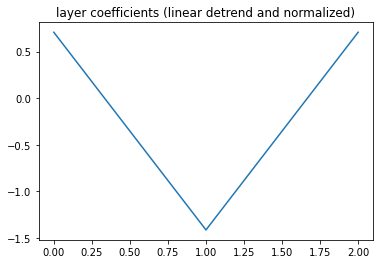

In [5]:
#plot_and_regress_layers(epi_control_mean, epi_seed_mean, epi_targets_mean)


seed = preproc(epi_seed_mean)
control = preproc(epi_control_mean)

layers = [preproc(l) for l in epi_targets_mean ]

# subtract the control (thalamus) from layers to remove ff and isolate fb signal
layers = [l - control for l in layers ]

layers = np.array(layers) 
layers.shape



#glm_input = seed - control 

# glm is just the seed (MT) fb signal 
glm_input = seed 


plt.figure()
plt.title('seed (glm_input), control timeseries')
plt.plot(seed, label='seed (LGN, glm_input)')
plt.plot(control, label='control (MT)')
#plt.plot(glm_input, label='seed - control')
plt.legend()


n=len(layers)
    
colors = pl.cm.jet(np.linspace(0,1,n))
colors = ['red','orange','green']



plt.figure()
plt.title('L_V1 layers')
for l in range(len(layers)):
    plt.plot(layers[l], label='V1_l{} - control (MT)'.format(l), color=colors[l])
plt.legend()



reg = linear_model.LinearRegression()

reg.fit(layers.T, glm_input)



coefs = reg.coef_

plt.figure()
plt.title('layer coefficients')
plt.plot(coefs)

plt.figure()
plt.title('layer coefficients (detrended and normalized)')
plt.plot(preproc(coefs))






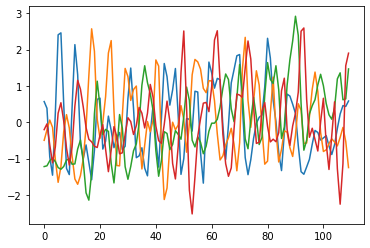

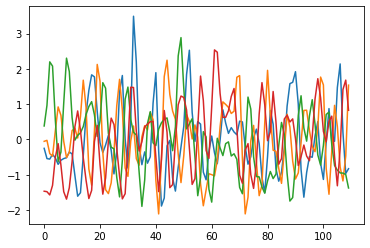

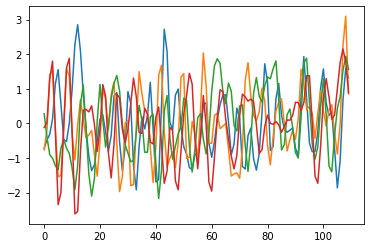

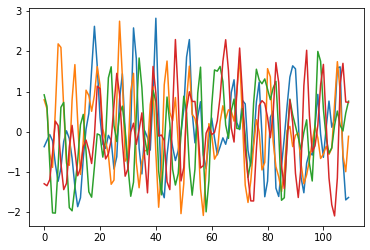

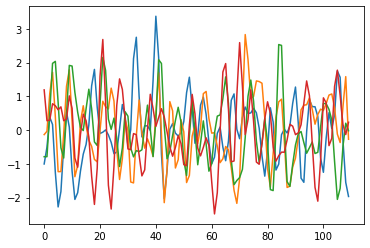

In [19]:
plt.figure() 
plt.plot()

plt.figure()
for p in pcas_seed: 
    plt.plot(p)

plt.figure()
for p in pcas_control: 
    plt.plot(p)


for p in pcas_targets: 
    plt.figure()

    for pp in p: 
        plt.plot(pp)
    

NameError: name 'glm_input' is not defined

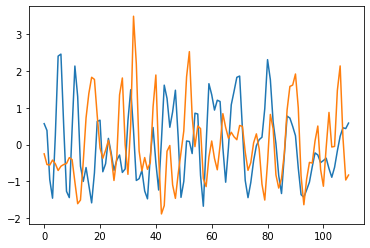

In [20]:
plt.figure() 
plt.plot(pcas_seed[0])
plt.plot(pcas_control[0])
plt.plot(glm_input)

plt.figure()
for p in epi_targets_mean:
    plt.plot(p)
    

In [ ]:

glm_input = epi_seed_mean - epi_control_mean
glm_input = pcas_seed[0] - pcas_control[0]

reg = linear_model.LinearRegression()

#reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])
reg.fit(epi_targets_mean.T, glm_input)


#LinearRegression()

reg.coef_


array([0.5, 0.5])



In [ ]:


epi_seed = data_epi[ind_seed]
epi_seed = data_epi[ind_seed]
epi_seed = data_epi[ind_seed]
epi_seed = data_epi[ind_seed]


affine = nii_seed.affine
ss = data_seed.shape





del nii_seed, nii_layers, nii_columns, nii_epi 


#out = np.zeros((ss[0], ss[1], ss[2],len(np.unique(data_layers))-1))
#out_ff = np.zeros((ss[0], ss[1], ss[2],1))
#out_fb = np.zeros((ss[0], ss[1], ss[2],1))
#out_other = np.zeros((ss[0], ss[1], ss[2],1))
#out_deep = np.zeros((ss[0], ss[1], ss[2],1))
#out_super = np.zeros((ss[0], ss[1], ss[2],1))




# GET SEED DATA, AVERAGE, DETREND, NORMALIZE 
# TODO: MAYBE VOXEL BY VOXEL - SEED TO TARGET 
# average epi
seed_ts_s       = data_epi[ind_seed]
seed_mean       = np.mean(seed_ts_s,0)
seed_ts_dt      = signal.detrend(seed_mean, type='linear')
seed_ts_dt_n    = (seed_ts_dt - np.mean(seed_ts_dt))/ np.std(seed_ts_dt)
seed_ts         = seed_ts_dt_n







unq_columns = np.unique(data_columns)
unq_columns = unq_columns[1:]

unq_layers = np.unique(data_layers)
unq_layers = unq_layers[1:]


data_layer_by_col_vox_ts = []
data_layer_by_col_vox_l = []
data_layer_by_col_vox_c = []
data_layer_by_col_vox_fill_c = []

for c in unq_columns:
    layer_corrs = []
    for l in unq_layers:
        bin_col = data_columns == c
        bin_layer = data_layers == l

        w = np.where((bin_col) & (bin_layer))

        fill_col = np.where(bin_col)

        if w[0].size == 0: 
            continue 


        X = data_epi[w[0],w[1],w[2]]
        X = X.T 

        scaler = StandardScaler()
        X_std = scaler.fit_transform(X) 

        ###########################
        # #NUMBER COMPONENTS 
        # pca = PCA()
        # X_pca = pca.fit(X_std)
        # X_pca.explained_variance_.shape 

        # num_components = 4
        # pca = PCA(num_components)  
        # X_pca = pca.fit_transform(X_std)

        ##########################
        # VARIANCE EXPLAINED 
        pca             = PCA(n_components = 0.99)
        X_pca           = pca.fit_transform(X_std) 
        n_pcs           = pca.n_components_ 

        most_important          = [ np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
        initial_feature_names   = [ x for x in range(0,X_std.shape[1])]
        most_important_names    = [ initial_feature_names[most_important[i]] for i in range(n_pcs)]

        num_timeseries = 4
        most_important_timeseries = [ X_std[:,x] for x in most_important_names[0:num_timeseries] ]


        plt.close()
        for x in most_important_timeseries: 
            plt.plot(x)
        plt.savefig('/home/kleinrl/plots/col_{}-layer_{}.png'.format(c,l))        
        plt.close() 


        '''
        plt.close()
        for x in most_important_names[0:num_timeseries]: 
            print('most imp: {}'.format(x))
            plt.plot(X_std[:,x])
        plt.savefig('fig1.png')        
        plt.close() 

        plt.plot(X_std[1,:])
        plt.plot(X_std[2,:])
        plt.plot(X_std[3,:])
        plt.savefig('fig2.png')   
        plt.close()

        plt.close()
        for x in most_important_timeseries: 
            plt.plot(x)
        plt.savefig('fig3.png')        
        plt.close() 

        '''




        #target_ts_mean          = np.mean(target_ts_list,0)
        #target_ts_mean_dt       = signal.detrend(target_ts_mean, type='linear')
        #target_ts_mean_dt_norm  = (target_ts_mean_dt - 
        #                            np.mean(target_ts_mean_dt))/ np.std(target_ts_mean_dt)

        #data_layer_by_col_vox_ts.append(target_ts_mean_dt_norm)
        data_layer_by_col_vox_ts.append(most_important_timeseries)

        data_layer_by_col_vox_l.append(l)
        data_layer_by_col_vox_c.append(c)
        data_layer_by_col_vox_fill_c.append(fill_col)




#for x in data_layer_by_col_vox_ts:





data_layer_by_col_vox_ts.append(seed_ts)
data_layer_by_col_vox_l.append('seed')
data_layer_by_col_vox_c.append('seed')
data_layer_by_col_vox_fill_c.append('seed')


d = np.array(data_layer_by_col_vox_ts)

d_corr = np.corrcoef(d)


out_strs = [] 

# TODO this could be sped up by just iterating
for i in range(0, d_corr.shape[0]-1, 3): # shape-1 to account for last row seed
    print('{} {} {} {}'.format(
        data_layer_by_col_vox_c[i], 
        data_layer_by_col_vox_l[i], 
        data_layer_by_col_vox_l[i+1],
        data_layer_by_col_vox_l[i+2]))

    layer_corrs = d_corr[-1,i:i+3]
    c = data_layer_by_col_vox_c[i]

    print("c: {} layers: {}".format(c,layer_corrs))



    str_ff, str_fb, str_deep, str_super, str_other = 0,0,0,0,0


    # build profile nifti 
    for ii in range(len(layer_corrs)):
        x,y,z = data_layer_by_col_vox_fill_c[i]
        out[x,y,z,ii] = layer_corrs[ii]

    # INPUT - layer 1 greater 0,2 
    if (layer_corrs[0] < layer_corrs[1]) & (layer_corrs[2] < layer_corrs[1]):
        out_ff[x,y,z] = layer_corrs[1]

        str_ff = 1

    # OUTPUT - layers 0,2 greater than 1
    elif (layer_corrs[0] > layer_corrs[1]) & (layer_corrs[2] > layer_corrs[1]):
        layer_corrs.sort()
        out_fb[x,y,z] = layer_corrs[-1] 

        str_fb = 1

    # DEEP - layer 0 greater than 1,2
    elif (layer_corrs[0] > layer_corrs[1]) & (layer_corrs[0] > layer_corrs[2]):
        out_deep[x,y,z] = layer_corrs[0] 

        str_deep = 1

    # SUPERFICIAL - layer 2 greater 0,1 
    elif (layer_corrs[2] > layer_corrs[0]) & (layer_corrs[2] > layer_corrs[1]):
        out_super[x,y,z] = layer_corrs[2] 

        str_super = 1

    else: 
        out_other[x,y,z] = 1 

        str_other = 1 


    # output data to text 

    # c  l1 l2 l3 ff fb deep super other
    #ID   r  r  r 01 01   01    01    01 

    s_out = "{} {} {} {} {} {}\n".format(c, 
    layer_corrs[0], layer_corrs[1], layer_corrs[2], 
    str_ff, str_fb, str_deep, str_super, str_other)

    out_strs.append(s_out)




    print("column done: {}".format(c))


nii_out = nib.Nifti1Image(out, affine)
nib.save(nii_out, '{}/{}.SEED2SEED.profile.nii'.format(outdir, out_prefix))

nii_out_ff = nib.Nifti1Image(out_ff, affine)
nib.save(nii_out_ff, '{}/{}.SEED2SEED.ff.nii'.format(outdir, out_prefix))

nii_out_fb = nib.Nifti1Image(out_fb, affine)
nib.save(nii_out_fb, '{}/{}.SEED2SEED.fb.nii'.format(outdir, out_prefix))

nii_out_other = nib.Nifti1Image(out_other, affine)
nib.save(nii_out_other, '{}/{}.SEED2SEED.other.nii'.format(outdir, out_prefix))

nii_out_deep= nib.Nifti1Image(out_deep, affine)
nib.save(nii_out_deep, '{}/{}.SEED2SEED.deep.nii'.format(outdir, out_prefix))

nii_out_super = nib.Nifti1Image(out_super, affine)
nib.save(nii_out_super, '{}/{}.SEED2SEED.super.nii'.format(outdir, out_prefix))


with open('{}/table.csv'.format(outdir),'w') as f: 
    f.write("c l1 l2 l3 ff fb deep super other\n")
    for s in out_strs: 
        f.write(s)
    f.close()




end = time.perf_counter()
diff = end - start 
print(diff)